## 1. Load Required Libraries
We'll begin by loading the necessary libraries and any custom functions provided in the `run_evSeq.py` file.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
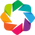

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [1]:
# Load necessary libraries
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from importlib import resources
import subprocess
from Bio import SeqIO
import tqdm
import re
import gzip
import shutil

# Add the path to the levseq directory to the system path
sys.path.append('../levseq')

# Import custom functions from the provided script
from run_levseq import *
result_folder = os.getcwd()

## 2. Define Run Location
We'll specify the location of the sequencing run data. This is also within the same directory structure.


In [2]:
os.getcwd()

'/Users/JLoong8/git/LevSeq/example'

In [3]:
# Define the path to the run data
run_location = '/Users/JLoong8/git/LevSeq/example/sample_data/parlq_ep1'
ref_df = pd.read_csv('/Users/JLoong8/git/LevSeq/example/sample_data/parlq_ep1/20240422-YL-ParLQ-ep1.csv')
name = 'Test-ep1'

## 3. Demultiplexing and variant calling
Demultiplexing is the process of separating out individual samples from a multiplexed sequencing run. We'll use the `demux_fastq` function from the custom script to perform this step.


In [4]:
# Create empty variant df
result_folder = os.path.join(result_folder, name)
variant_df = pd.DataFrame(columns=["barcode_plate", "name", "refseq", "variant"])

for i, row in ref_df.iterrows():
    barcode_plate = row["barcode_plate"]
    name = row["name"]
    refseq = row["refseq"].upper()

    # Create a subfolder for the current iteration using the name value
    name_folder = os.path.join(result_folder, name)
    os.makedirs(name_folder, exist_ok=True)

    # Write the refseq to a temporary fasta file
    temp_fasta_path = os.path.join(name_folder, f"temp_{name}.fasta")
    with open(temp_fasta_path, "w") as f:
        f.write(f">{name}\n{refseq}\n")
    # Create filtered barcode path
    f_min = 1
    f_max = 96
    rbc = i+1
    front_prefix = "NB"
    back_prefix = "RB"
    barcode_path = "../levseq/barcoding/minion_barcodes.fasta"
    barcode_path_filter = os.path.join(name_folder, "minion_barcodes_filtered.fasta")
    filter_barcodes(
        barcode_path,
        barcode_path_filter,
        (f_min, f_max),
        rbc,
        front_prefix,
        back_prefix,)
    
    # Perform demultiplexing
    demux_fastq(run_location, name_folder, barcode_path_filter)
    
    variant_result = call_variant(f"{name}", name_folder, temp_fasta_path, barcode_path_filter)
    variant_result["barcode_plate"] = barcode_plate
    variant_result["name"] = name
    variant_result["refseq"] = refseq
    variant_df = pd.concat([variant_df, variant_result])
variant_df.to_csv(variant_csv_path, index=False)

/opt/anaconda3/envs/LevSeq/lib/python3.8/site-packages/levseq/barcoding/demultiplex
Processed argument: -f with value: /Users/JLoong8/git/LevSeq/example/sample_data/parlq_ep1
Processed argument: -d with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/300-1
Processed argument: -b with value: /Users/JLoong8/git/LevSeq/example/Test-ep1/300-1/minion_barcodes_filtered.fasta
Processed argument: -w with value: 100
Processed argument: -r with value: 100
Processed argument: -m with value: 800
Processed argument: -x with value: 5000
Number of files: 2
Processing files: [#########################                         ] 50%


  0%|                                                                          | 0/9 [00:00<?, ?it/s]

  0%|                                                                          | 0/9 [00:00<?, ?it/s]




  0%|                                                                          | 0/9 [00:00<?, ?it/s]


  0%|                                                                          | 0/9 [00:00<?, ?it/s]





Writing MSAWriting MSA

Writing MSA
Writing MSA
Writing MSA
Writing MSA


  0%|                                                                          | 0/9 [00:00<?, ?it/s]






  0%|                                                                          | 0/9 [00:00<?, ?it/s]







  0%|                                                                          | 0/9 [00:00<?, ?it/s]







Writing MSA
Writing MSA
Writing MSA


  0%|                                                                          | 0/9 [00:00<?, ?it/s]








  0%|                                                                          | 0/9 [00:00<?, ?it/s]

Writing MSA
Writing MSA







 11%|███████▎                                                          | 1/9 [00:01<00:10,  1.25s/it]

 11%|███████▎                                                          | 1/9 [00:01<00:10,  1.28s/it]


 11%|███████▎                                                          | 1/9 [00:01<00:11,  1.43s/it]








Writing MSA
Writing MSA
Writing MSA


 11%|███████▎                                                          | 1/9 [00:01<00:10,  1.30s/it]



 11%|███████▎                                                          | 1/9 [00:01<00:11,  1.40s/it]







 33%|██████████████████████                                            | 3/9 [00:01<00:03,  1.81it/s]

Writing MSA
Writing MSA
Writing MSA








 11%|███████▎                                                          | 1/9 [00:01<00:10,  1.33s/it]








 11%|███████▎                                                          | 1/9 [00:01<00:10,  1.26s/it]

Writing MSA
Writing MSA
Writing MSA
Writing MSA







 22%|██████████████▋                                                   | 2/9 [00:02<00:10,  1.45s/it]


 22%|██████████████▋                                                   | 2/9 [00:02<00:10,  1.50s/it]



 22%|██████████████▋                                                   | 2/9 [00:02<00:09,  1.40s/it]

 22%|██████████████▋                                                   | 2/9 [00:03<00:10,  1.55s/it]

Writing MSA
Writing MSA










 22%|██████████████▋                                                   | 2/9 [00:02<00:09,  1.41s/it]






 22%|██████████████▋                                                   | 2/9 [00:03<00:11,  1.64s/it]

Writing MSA
Writing MSA
Writing MSA
Writing MSA
Writing MSA








 22%|██████████████▋                                                   | 2/9 [00:02<00:09,  1.42s/it]






 33%|██████████████████████                                            | 3/9 [00:03<00:05,  1.15it/s]








 22%|██████████████▋                                                   | 2/9 [00:02<00:09,  1.39s/it]

Writing MSA
Writing MSA
Writing MSA
Writing MSA







 33%|██████████████████████                                            | 3/9 [00:04<00:08,  1.38s/it]




 44%|█████████████████████████████▎                                    | 4/9 [00:04<00:04,  1.10it/s]


 33%|██████████████████████                                            | 3/9 [00:04<00:08,  1.48s/it]

Writing MSA
Writing MSA










 33%|██████████████████████                                            | 3/9 [00:04<00:08,  1.40s/it]

 33%|██████████████████████                                            | 3/9 [00:04<00:09,  1.54s/it]





Writing MSA
Writing MSA
Writing MSA


 33%|██████████████████████                                            | 3/9 [00:04<00:09,  1.65s/it]





 33%|██████████████████████                                            | 3/9 [00:04<00:09,  1.53s/it]

Writing MSA
Writing MSA


 56%|████████████████████████████████████▋                             | 5/9 [00:05<00:04,  1.17s/it]






 44%|█████████████████████████████▎                                    | 4/9 [00:04<00:06,  1.25s/it]








 33%|██████████████████████                                            | 3/9 [00:04<00:09,  1.66s/it]

Writing MSA
Writing MSA
Writing MSA
Writing MSA







 56%|████████████████████████████████████▋                             | 5/9 [00:05<00:04,  1.09s/it]


 44%|█████████████████████████████▎                                    | 4/9 [00:05<00:07,  1.45s/it]

 44%|█████████████████████████████▎                                    | 4/9 [00:06<00:07,  1.50s/it]







 44%|█████████████████████████████▎                                    | 4/9 [00:05<00:07,  1.43s/it]

Writing MSA
Writing MSA
Writing MSA
Writing MSA






 44%|█████████████████████████████▎                                    | 4/9 [00:06<00:08,  1.65s/it]





 44%|█████████████████████████████▎                                    | 4/9 [00:06<00:08,  1.66s/it]








 44%|█████████████████████████████▎                                    | 4/9 [00:06<00:07,  1.51s/it]

Writing MSA
Writing MSA
Writing MSA


 67%|████████████████████████████████████████████                      | 6/9 [00:06<00:04,  1.34s/it]






 56%|████████████████████████████████████▋                             | 5/9 [00:06<00:05,  1.42s/it]



Writing MSA
Writing MSA
Writing MSA


 56%|████████████████████████████████████▋                             | 5/9 [00:07<00:05,  1.40s/it]




 67%|████████████████████████████████████████████                      | 6/9 [00:07<00:03,  1.22s/it]

Writing MSA
Writing MSA





 56%|████████████████████████████████████▋                             | 5/9 [00:07<00:06,  1.58s/it]







 56%|████████████████████████████████████▋                             | 5/9 [00:07<00:06,  1.52s/it]

Writing MSA
Writing MSA






 56%|████████████████████████████████████▋                             | 5/9 [00:07<00:06,  1.61s/it]





 56%|████████████████████████████████████▋                             | 5/9 [00:07<00:06,  1.57s/it]

Writing MSA
Writing MSA











 78%|███████████████████████████████████████████████████▎              | 7/9 [00:08<00:02,  1.49s/it]






 67%|████████████████████████████████████████████                      | 6/9 [00:08<00:04,  1.54s/it]

Writing MSA
Writing MSA
Writing MSA


 89%|██████████████████████████████████████████████████████████▋       | 8/9 [00:08<00:01,  1.08s/it]

 67%|████████████████████████████████████████████                      | 6/9 [00:08<00:04,  1.50s/it]






 78%|███████████████████████████████████████████████████▎              | 7/9 [00:08<00:02,  1.13s/it]

Writing MSAWriting MSA

Writing MSA







 78%|███████████████████████████████████████████████████▎              | 7/9 [00:09<00:02,  1.43s/it]







 67%|████████████████████████████████████████████                      | 6/9 [00:08<00:04,  1.52s/it]

Writing MSA
Writing MSA






 67%|████████████████████████████████████████████                      | 6/9 [00:09<00:04,  1.51s/it]


 67%|████████████████████████████████████████████                      | 6/9 [00:09<00:05,  1.67s/it]

Writing MSA
Writing MSA








 67%|████████████████████████████████████████████                      | 6/9 [00:09<00:04,  1.58s/it]

Writing MSA
Writing MSA











 67%|████████████████████████████████████████████                      | 6/9 [00:10<00:05,  1.74s/it]

Writing MSA




100%|██████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.16s/it]


Writing MSA
Writing MSA







  0%|                                                                          | 0/6 [00:00<?, ?it/s]






 89%|██████████████████████████████████████████████████████████▋       | 8/9 [00:10<00:01,  1.28s/it]







 78%|███████████████████████████████████████████████████▎              | 7/9 [00:10<00:03,  1.53s/it]

Writing MSA
Writing MSA
Writing MSA






 78%|███████████████████████████████████████████████████▎              | 7/9 [00:10<00:03,  1.50s/it]

Writing MSA
Writing MSA








 78%|███████████████████████████████████████████████████▎              | 7/9 [00:10<00:03,  1.53s/it]








 78%|███████████████████████████████████████████████████▎              | 7/9 [00:10<00:03,  1.52s/it]

Writing MSA
Writing MSA





 78%|███████████████████████████████████████████████████▎              | 7/9 [00:11<00:03,  1.64s/it]

Writing MSA
Writing MSA







100%|██████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.46s/it]






100%|██████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.36s/it]


 89%|██████████████████████████████████████████████████████████▋       | 8/9 [00:12<00:01,  1.62s/it]



 89%|██████████████████████████████████████████████████████████▋       | 8/9 [00:12<00:01,  1.46s/it]







 17%|███████████                                                       | 1/6 [00:01<00:09,  1.90s/it]

Writing MSA
Writing MSA
Writing MSA


 33%|██████████████████████                                            | 2/6 [00:02<00:03,  1.16it/s]





 89%|██████████████████████████████████████████████████████████▋       | 8/9 [00:12<00:01,  1.52s/it]








 89%|██████████████████████████████████████████████████████████▋       | 8/9 [00:12<00:01,  1.46s/it]

Writing MSA
Writing MSA
Writing MSA



 89%|██████████████████████████████████████████████████████████▋       | 8/9 [00:12<00:01,  1.48s/it]


 89%|██████████████████████████████████████████████████████████▋       | 8/9 [00:13<00:01,  1.68s/it]

Writing MSA
Writing MSA
Writing MSA




100%|██████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.52s/it]



100%|██████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.40s/it]







100%|██████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.48s/it]






100%|██████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.38s/it]








100%|██████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.48s/it]



100%|██████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.47s/it]

100%|██████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.54s/it]


Writing MSA


 83%|███████████████████████████████████████████████████████           | 5/6 [00:03<00:00,  1.98it/s]

Writing MSA
Writing MSA


100%|██████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]


KeyboardInterrupt: 

## 4. Create variant and visualization csv files

In [ ]:
variant_df

## 5. Visualization
Finally, we'll visualize the results using appropriate visualization functions. This step helps in understanding the distribution and impact of the identified variants.

In [ ]:
df_variants, df_vis = create_df_v(variant_df)
layout = generate_platemaps(
            max_combo_data=df_vis,
            result_folder=result_folder,)   
layout